In [122]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

%matplotlib inline

In [123]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [124]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)


In [125]:
domain = [0, 6]
n_discretization = 100 * domain[1] - domain[0]

In [126]:
n_input = 1
n_output = 1
eps = 1e-10

In [127]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [128]:
mlp = nn.Sequential(
  nn.Linear(n_input, 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),        
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()

In [129]:
def get_loss(x, ret_res=False):    
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [130]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [131]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 1000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00001.0655710362
Step: 002 loss = 00001.0534054457
Step: 004 loss = 00000.9852727853
Step: 006 loss = 00000.8943816343
Step: 008 loss = 00000.7077480497
Step: 010 loss = 00000.6133610390
Step: 012 loss = 00000.2408872702
Step: 014 loss = 00000.2107339434
Step: 016 loss = 00000.2765496461
Step: 018 loss = 00000.3265229833
Step: 020 loss = 00000.2350290323
Step: 022 loss = 00000.2119057935
Step: 024 loss = 00000.1262227486
Step: 026 loss = 00000.0465617412
Step: 028 loss = 00000.0861378281
Step: 030 loss = 00000.0928648748
Step: 032 loss = 00000.0474415839
Step: 034 loss = 00000.0585837820
Step: 036 loss = 00000.0446142050
Step: 038 loss = 00000.0440694331
Step: 040 loss = 00000.0306433852
Step: 042 loss = 00000.0372884340
Step: 044 loss = 00000.0337428902
Step: 046 loss = 00000.0337934659
Step: 048 loss = 00000.0336176952
Step: 050 loss = 00000.0291198078
Step: 052 loss = 00000.0304708838
Step: 054 loss = 00000.0257550147
Step: 056 loss = 00000.0265992943
Step: 058 loss

In [132]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,0.0000065660622545
1,0.1000000000000000,0.0016710166632401
2,0.2000000000000000,0.0066623375740185
3,0.5000000000000000,0.0415711790279658
4,1.0000000000000000,0.1658358381390787
5,1.5000000000000000,0.3707155098599880
6,2.0000000000000000,0.6510035639829249


In [133]:
# f''(0)
d2y_dx2(mlp(x), x)[0]

tensor([0.3326], dtype=torch.float64, grad_fn=<SelectBackward0>)

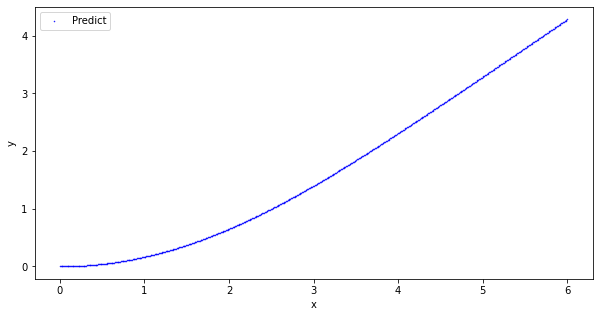

In [134]:
#[TODO]
domain = x.detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

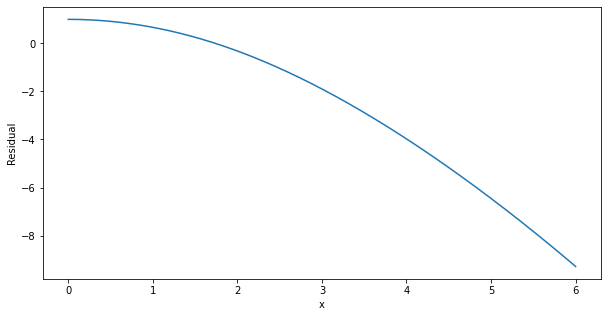

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(domain, exact - predict, label='residual')
plt.xlabel('x')
plt.ylabel('Residual')
plt.savefig('residual-exact.eps', bbox_inches='tight', format='eps')


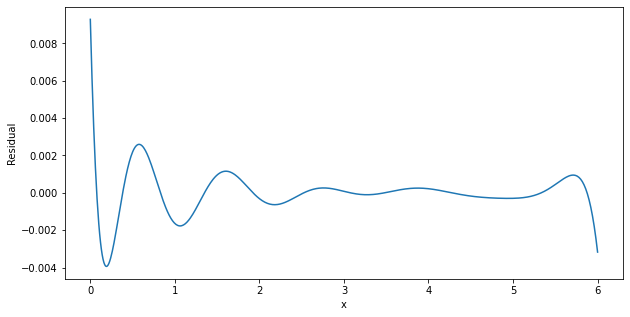

In [136]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

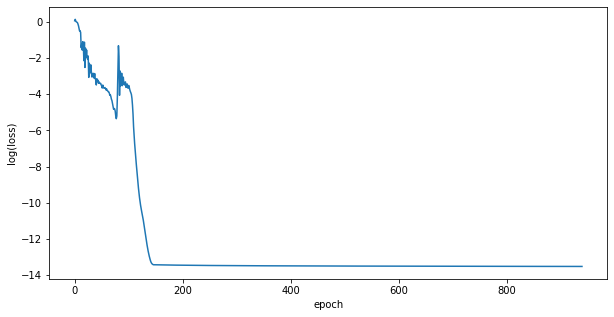

In [137]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')

In [138]:

def l1_norm(vector0, vector1):
  return sum(abs(a-b) for a, b in zip(vector0, vector1))

def l_inf_norm(vector0, vector1):
  return max(abs(a-b) for a, b in zip(vector0, vector1))

def l2_norm(vector0, vector1):
  return (sum((a-b)**2 for a, b in zip(vector0, vector1))) ** .5

def relative_l2(vector0, vector1):
  return np.linalg.norm(vector0 - vector1, 2)/np.linalg.norm(vector0,2)


measure_names = []
measure_values = []
for measure in [
  mean_squared_error,
  l1_norm,
  l2_norm,
  l_inf_norm,
  relative_l2,
  mean_absolute_error

]:
  measure_names.append(measure.__name__)
  measure_values.append(measure(exact, predict))
df = pd.DataFrame(dict(name=measure_names, values=measure_values)).reset_index(drop=True)
print(df.to_latex(), file=open('latex_table.txt', 'w'))
df

/tmp/ipykernel_375040/3153791773.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(), file=open('latex_table.txt', 'w'))


,name,values
0,mean_squared_error,16.8084777862572636
1,l1_norm,1820.6982613152511021
2,l2_norm,100.4245322207395361
3,l_inf_norm,9.2848153531846567
4,relative_l2,1.9970140805279091
5,mean_absolute_error,3.0344971021920846
